# HW9: Forecasting Solar Cycles

Below is the notebook associated with HW\#9. You can run the notebook in two modes. If you have the `emcee` and `corner` packages installed on your machine, along with the data files, just keep the following variable set to `False`. If you are running it in a Google colab notebook, set it to `True` so that it will grab the packages and files. Remember that the Google colab environment will shutdown after ~1 hour of inactivity, so you'll need to keep interacting with it or else will lose the data.

A script version of this file will also be provided to you, but you cannot use this in a Google colab environment

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
import emcee
import corner
import tqdm
%matplotlib inline

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

## Defining my model

Here I define my model. My model can be expressed as:

$X_t = \phi_1 X_{t-1} + \phi_{12} X_{t-12} + \phi_{132} X_{t-132}+Z_t$

The first term represents the current value's relation to the previous value.  
The second term represents the current value's relation to the value from one year ago.  
The third term represents the current value's relation to the value from 11 years ago.  
The last term is the noise (shock).  

  
  
So the parameters I want to fit will be: $\phi_1, \phi_{12}, \phi_{132}$

In [2]:
def model(xs, t, p1, p2, p3):
    """
    Parameters
    ----------
    xs: x-values of the data
    t: a specific index of time
    p1, p2, p3: parameters to fit
    
    Returns
    -------
    functional value X(t) for input t value 
    """
    
    idx = t
    
    x = np.zeros(len(xs))
    for t in range(len(xs)):
        x[t] = p1 * xs[t-1] + p2 * xs[t-12] + p3 * xs[t-132]
    
    return(x[idx])


## Define the (log-)priors

Here, the function should take a vector of parameters, `theta`, and return `0.0` if the it is in the prior range and `-np.inf` if it is outside. This is equivalent to a uniform prior over the parameters. You can, of course, define a different set of priors if you so choose!

In [3]:
def lnprior(theta):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
        
    Returns
    -------
    Value of log-prior.    
    """
    
    p1, p2, p3  = theta
    if (-1.0 < p1 < 1.0) and (-1.0 < p2 < 1.0) and (-1.0 < p3 < 1.0):
        return(0.0)
    return(-np.inf)

## Define the (log-)likelihood

In [4]:
def lnlike(theta, data):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
    data : np.ndarray
        
        
    Returns
    -------
    Value of log-likelihood   
    """
    p1, p2, p3 = theta
    ys = data
    
    ts = np.arange(len(ys))
        
    sum = 0
    for t, y in zip(ts, ys):
        sum += -0.5 * (y - model(ys, t, p1, p2, p3))**2
    l = np.log(1/np.sqrt(2*np.pi)) + sum
    lexp = np.exp(l)
    
    return(lexp)

## Define total (log-)probability

No need to change this if the other two functions work as described.

In [5]:
def lnprob(theta, data):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data)

## Set up the MCMC sampler here

In [6]:
# Number of walkers to search through parameter space
nwalkers = 10

# Number of iterations to run the sampler for
niter = 50

# Initial guess of parameters. For example, if you had a model like
# s(t) = a + bt + ct^2
# and your initial guesses for a, b, and c were 5, 3, and 8, respectively, then you would write
# pinit = np.array([5, 3, 8])
# Make sure the guesses are allowed inside your lnprior range!
pinit = np.array([0.5, 0.5, 0.5])

# Number of dimensions of parameter space
ndim = len(pinit)

# Perturbed set of initial guesses. Have your walkers all start out at
# *slightly* different starting values
p0 = [pinit + 1e-4*pinit*np.random.randn(ndim) for i in range(nwalkers)]

## Load the data, plot to show

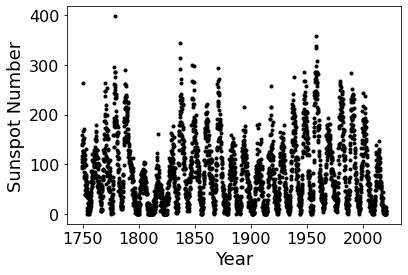

In [7]:
# Data: decimal year, sunspot number
decyear, ssn = np.loadtxt("SN_m_tot_V2.0.txt", unpack=True, usecols=(2, 3))
plt.plot(decyear, ssn, 'k.')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.show()

## Run the sampler

In [9]:
# Number of CPU threads to use. Reduce if you are running on your own machine
# and don't want to use too many cores
nthreads = 4
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(ssn,), threads=nthreads)
# Run the sampler. May take a while! You might consider changing the 
# number of iterations to a much smaller value when you're testing. Or use a 
# larger value when you're trying to get your final results out!
sampler.run_mcmc(p0, niter, progress=True)

100%|██████████| 50/50 [58:05<00:00, 69.70s/it] 


State([[ 0.38618875  0.80132218  0.91523621]
 [-0.38454604  0.28991887 -0.70321429]
 [ 0.41944254  0.47594607  0.4736754 ]
 [ 0.97287256  0.24556888  0.58241849]
 [-0.43042449  0.0107185   0.82467643]
 [ 0.61931944  0.68981265  0.76744517]
 [ 0.38256125  0.50195359  0.61056942]
 [ 0.84850569  0.80245076  0.05665543]
 [ 0.27993782  0.89240174  0.30131837]
 [ 0.79331806  0.00910253  0.23621248]], log_prob=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], blobs=None, random_state=('MT19937', array([3716293814,  194771225, 1832298127, 2855231246, 4216431151,
       2596561704, 1814394259, 2404541176,  683163942, 3933642057,
        217895877, 2433997201, 2690647723, 3308981953,  665237563,
        547968675, 1111707364, 3716407984,  835437272, 2135122632,
        217899813, 1347998047, 3005743442, 3407520110, 4196276186,
        151997287, 1584306213, 1207472201, 2133565597, 3769313768,
       1395841025,  561408073, 3260743751,  747993346, 2108400656,
       1424305134, 1876071494, 1713563385, 4006598925,

## Get the samples in the appropriate format, with a burn value

In [10]:
# Burn-in value = 1/4th the number of iterations. Feel free to change!
burn = int(0.25*niter)
# Reshape the chains for input to corner.corner()
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))

## Make a corner plot

You should feel free to adjust the parameters to the `corner` function. You **should** also add labels, which should just be a list of the names of the parameters. So, if you had two parameters, $\phi_1$ and $\phi_2$, then you could write:

```
labels = [r"$\phi_1$", r"$\phi_2$"]
```

and that will make the appropriate label in LaTeX (if the distribution is installed correctly) for the two 1D posteriors of the corner plot.

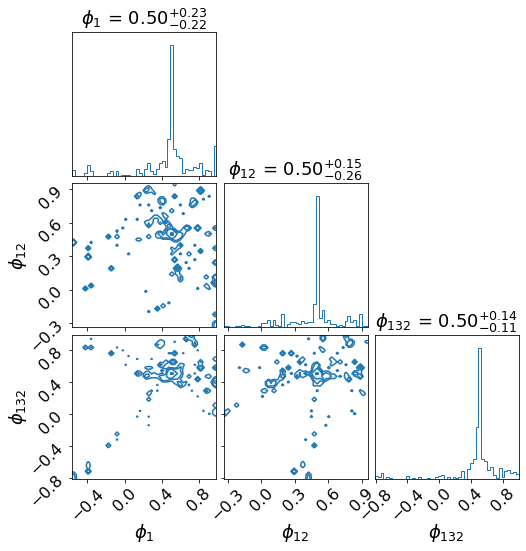

In [12]:
label = [r"$\phi_1$", r"$\phi_{12}$", r"$\phi_{132}$"]

fig = corner.corner(samples, bins=50, color='C0', smooth=0.5, plot_datapoints=False, plot_density=True, \
                    plot_contours=True, fill_contour=False, show_titles=True, labels=label)
#fig.savefig("corner.png")
plt.show()

## Overplot the model on the data

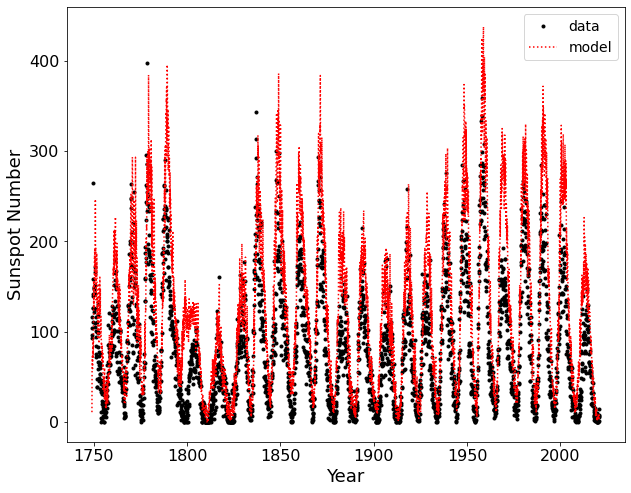

In [45]:
#First, need to slightly modify the definition of function that will work differently than before
def model_2(theta, xs): 
    p1, p2, p3 = theta
    x = np.zeros(len(xs))
    for t in range(len(xs)):
        x[t] = p1 * xs[t-1] + p2 * xs[t-12] + p3 * xs[t-132]
    return(x)
    

#Get model
theta_max = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model_2(theta_max, ssn)


#Overplot model on data
plt.figure(figsize=(10,8))
plt.plot(decyear, ssn, 'k.', label = "data")
plt.plot(decyear, best_fit_model, 'r:', label = "model")
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

## Compute and plot the residuals

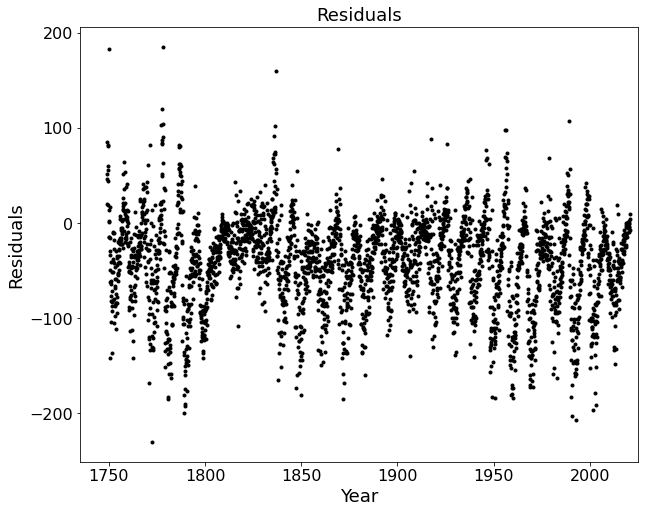

In [46]:
residuals = ssn - best_fit_model

plt.figure(figsize=(10,8))
plt.xlim(1735, 2025)
plt.plot(decyear, residuals, 'k.')
plt.title('Residuals')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.show()

## Determine the standard deviation of the perturbations

In [47]:
sigma_z = np.std(residuals)

print(sigma_z)

47.55751313535295


## Plot Spectrum of model

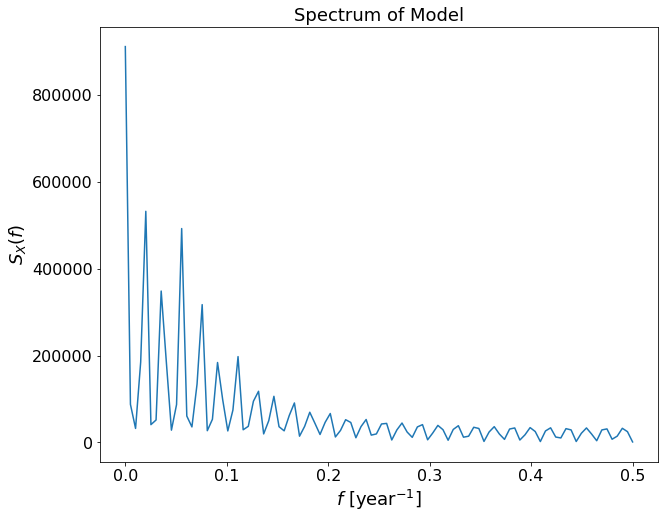

In [57]:
f = np.linspace(0, 0.5, 100) #0 < omega < pi ==> 0 < f < 1/2

phi_1, phi_2, phi_3 = 0.50, 0.60, 0.44
sigma_z = 47.0639

num = sigma_z**2 * abs(1 - 1/phi_1*np.exp(-2j*np.pi*f*1) - 1/phi_2*np.exp(-2j*np.pi*f*12) * 1/phi_3*np.exp(-2j*np.pi*f*132))**2
den = abs(1 - phi_1*np.exp(-2j*np.pi*f*1) - phi_2*np.exp(-2j*np.pi*f*12) * phi_3*np.exp(-2j*np.pi*f*132))**2

S_X_f = num / den


plt.figure(figsize=(10,8))
plt.plot(f, S_X_f)
plt.title('Spectrum of Model')
plt.xlabel(r"$f$ [year$^{-1}$]")
plt.ylabel(r"$S_X(f)$")
plt.show()


## Predict number of sunspots out to the year 2050

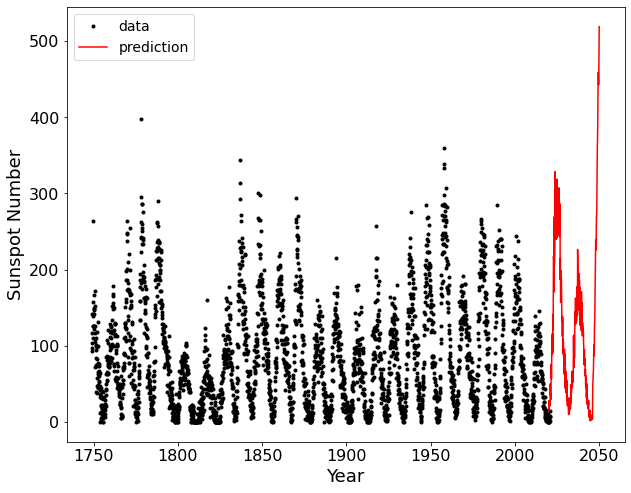

In [56]:
phi_1, phi_12, phi_132 = 0.50, 0.50, 0.50
theta = [phi_1, phi_12, phi_132]

def predict(theta, model, year):
    
    p1, p2, p3 = theta
    
    extra = int((year - model[-1]) / (model[1] - model[0])) #number of extra data points needed out to year 2050
    
    x = np.concatenate((model, np.zeros(int(extra)))) #make array of model points and then extra 0 points
    
    for t in range(len(model), len(model) + extra): #loop through only the zero points to populate with model
        x[t] = p1 * x[t-1] + p2 * x[t-12] + p3 * x[t-132]

    return(x)


x = predict(theta, best_fit_model, 2050)
t = np.linspace(1750, 2050, len(x))




plt.figure(figsize=(10,8))
plt.plot(decyear, ssn, 'k.', label = "data")
plt.plot(t[t>2020], x[t>2020], color = 'r', label = "prediction")
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()
